# `AZDIAS` + `CUSTOMERS` dataset

# 00. Importing packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    from tqdm import tqdm
except:
    !pip install tqdm
    from tqdm import tqdm    
%matplotlib inline


### my utils
from sklearn.preprocessing import OrdinalEncoder
from eda_utils import *

# 01. Loading datasets

In [2]:
customers = pd.read_csv("../arvato_data_processed/customers.csv", low_memory = False, index_col = 'LNR')
azdias = pd.read_csv("../arvato_data_processed/azdias.csv", low_memory = False, index_col = 'LNR')

customers_feature_types =  pd.read_csv("../arvato_data_processed/customers_feature_types.csv", low_memory = False,index_col='Attribute' )
azdias_feature_types =  pd.read_csv("../arvato_data_processed/azdias_feature_types.csv", low_memory = False,index_col='Attribute' )

print(customers_feature_types.shape,azdias_feature_types.shape)

customers_features = set(customers_feature_types['Attribute.1'])
azdias_features = set(azdias_feature_types['Attribute.1']) 

(333, 2) (332, 2)


# 02. Common features

In [3]:
common_features=  customers_features.intersection(azdias_features)
len(common_features)

330

We have 330 features in common, let's see what features are missing. We know from previous notebooks that `customers` initially had 3 more features than `azdias` dataset:

In [4]:
customers_features.difference(azdias_features)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [5]:
azdias_features.difference(customers_features)

{'KKK', 'REGIOTYP'}

So, after applying filtering for missingness in `azdias` and `customers` we have 330 common features.

Three features present in `customers` are lacking entires in `azdias`:
1. `CUSTOMER_GROUP`
2. `ONLINE_PURCHASE`
3. `PRODUCT_GROUP`

These features are related to the customer-related information for which we **naturally don't have general population equivalent**: 1. what is the group of the customer (single/multiple buyer), 2. whether it bought something online from us, 3. what category of product was it

Whereas customers lack two features present in general population:

1. `KKK` - purchasing power
2. `REGIOTYP` - neighbourhood, one of several possible classes: unknown, upper class, conservatives, upper middle class, middle class, lower middle class, traditional workers, marginal groups

In [6]:
azdias = azdias[common_features]
customers = customers[common_features]

In [7]:
customers['dataset'] = 'customers'
azdias['dataset'] = 'azdias'

In [8]:
joint_dataset = pd.concat([customers,azdias])
assert customers.shape[0]+azdias.shape[0]==joint_dataset.shape[0]

joint_dataset.head(5)

,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,ANREDE_KZ,KBA13_TOYOTA,KBA13_BAUMAX,SEMIO_TRADV,KBA05_ZUL2,FINANZ_MINIMALIST,CJT_TYP_3,CJT_TYP_2,D19_SAMMELARTIKEL_RZ,dataset
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,3.0,1.0,1.0,0,0.0,0,3.0,3.0,...,1,2.0,1.0,1,4.0,5,5.0,1.0,6,customers
143872,1.0,3.0,4.0,3.0,5.0,0,1.0,0,2.0,2.0,...,2,3.0,3.0,1,4.0,5,5.0,2.0,6,customers
143873,2.0,1.0,3.0,1.0,2.0,0,0.0,0,4.0,4.0,...,1,5.0,1.0,4,3.0,5,5.0,1.0,0,customers
143874,1.0,1.0,4.0,2.0,3.0,0,1.0,3,2.0,1.0,...,1,3.0,2.0,4,3.0,3,3.0,3.0,6,customers
143888,1.0,5.0,3.0,2.0,4.0,0,0.0,0,2.0,3.0,...,1,4.0,1.0,4,3.0,5,5.0,1.0,0,customers


In [9]:
msg = "The joint dataset has {} rows. The first {} rows are coming from customers dataset, the latter {} come from general population, i.e. AZDIAS dataset".format(
joint_dataset.shape[0], customers.shape[0],azdias.shape[0])
print(msg)

The joint dataset has 932108 rows. The first 140864 rows are coming from customers dataset, the latter 791244 come from general population, i.e. AZDIAS dataset


In [10]:
joint_dataset.shape[0] == customers.shape[0]+azdias.shape[0]

True

In [11]:
# free memory
del customers
del azdias

# 03. Features

## 03.01. Standardizing features

Upon inspecting metadata attributes in `DIAS Attributes - Values 2017.xlsx` I've found that there are a couple of features that need re-encoding:

- `LP_FAMILIE_GROB` must be standardized. As initially there are multiple labels that refer to the same class!
    - from documentation: 
     ```
     1 -> single
     2 - > couple
     3,4,5 -> single parent
     6,7,8 -> family
     9,10,11 -> multiperson household
     
     ```
     
     
I will replace all secondary values for a class with the first value of a class. Also, there seems to be a value `0` present, but for which we don't have any information, I'll replace `0` with NA

In [12]:

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


joint_dataset['LP_FAMILIE_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(7,6,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(8,6,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(10,9,inplace=True)
joint_dataset['LP_FAMILIE_GROB'].replace(11,9,inplace=True)

joint_dataset['LP_FAMILIE_GROB'].replace(0,np.nan,inplace=True)


print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_FAMILIE_GROB'].dropna())))


Before standarization we have classes: [0. 1. 2. 3. 4. 5.]
After standarization we have classes: [1. 2. 3.]


- `LP_STATUS_GROB` is a feature that encodes the same class with different labels. From the provided metadata in Exel file we know:
   ```
   1,2 - > low-income earners
   3,4,5 -> average,erners
   6,7 -> independants
   8,9 -> houseowners
   10 -> top earners
   
   ```
   

In [13]:
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))

joint_dataset['LP_STATUS_GROB'].replace(2,1,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(4,3,inplace=True)
joint_dataset['LP_STATUS_GROB'].replace(5,3,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(7,6,inplace=True)

joint_dataset['LP_STATUS_GROB'].replace(9,8,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['LP_STATUS_GROB'].dropna())))


Before standarization we have classes: [1. 2. 3. 4. 5.]
After standarization we have classes: [1. 3.]


- `PRAEGENDE_JUGENDJAHRE` could be simplified, thus I create a new feature: `PRAEGENDE_JUGENDJAHRE_SIM` to collapse a couple of classes together based on metadata:


initial classes:
```
1	40ies - war years (Mainstream, O+W)
2	40ies - reconstruction years (Avantgarde, O+W)
3	50ies - economic miracle (Mainstream, O+W)
4	50ies - milk bar / Individualisation (Avantgarde, O+W)
5	60ies - economic miracle (Mainstream, O+W)
6	60ies - generation 68 / student protestors (Avantgarde, W)
7	60ies - opponents to the building of the Wall (Avantgarde, O)
8	70ies - family orientation (Mainstream, O+W)
9	70ies - peace movement (Avantgarde, O+W)
10	80ies - Generation Golf (Mainstream, W)
11	80ies - ecological awareness (Avantgarde, W)
12	80ies - FDJ / communist party youth organisation (Mainstream, O)
13	80ies - Swords into ploughshares (Avantgarde, O)
14	90ies - digital media kids (Mainstream, O+W)
15	90ies - ecological awareness (Avantgarde, O+W)
```
simplified classes:

```
    1,2 -> 40ies
    3,4 -> 50ies
    5,6,7 -> 60ies
    8,9 -> 70ies
    10,11,12,13 -: 80ies
    14,15 -> 90ies

```


In [14]:
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM']= joint_dataset['PRAEGENDE_JUGENDJAHRE']

print("Before standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE'].dropna())))

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(2,1,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(4,3,inplace=True)

joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(6,5,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(7,5,inplace=True)
 
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(9,8,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(11,10,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(12,10,inplace=True)
joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(13,10,inplace=True)


joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].replace(15,14,inplace=True)

print("After standarization we have classes: {}".format(np.unique(joint_dataset['PRAEGENDE_JUGENDJAHRE_SIM'].dropna())))


Before standarization we have classes: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
After standarization we have classes: [ 1.  3.  5.  8. 10. 14.]


- `CAMEO_DEUINTL_2015` can be also generalized/simplified: to `CAMEO_DEUINTL_2015_SIM`

original annotations
```
11	Wealthy Households-Pre-Family Couples & Singles
12	Wealthy Households-Young Couples With Children
13	Wealthy Households-Families With School Age Children
14	Wealthy Households-Older Families &  Mature Couples
15	Wealthy Households-Elders In Retirement
21	Prosperous Households-Pre-Family Couples & Singles
22	Prosperous Households-Young Couples With Children
23	Prosperous Households-Families With School Age Children
24	Prosperous Households-Older Families & Mature Couples
25	Prosperous Households-Elders In Retirement
31	Comfortable Households-Pre-Family Couples & Singles
32	Comfortable Households-Young Couples With Children
33	Comfortable Households-Families With School Age Children
34	Comfortable Households-Older Families & Mature Couples
35	Comfortable Households-Elders In Retirement
41	Less Affluent Households-Pre-Family Couples & Singles
42	Less Affluent Households-Young Couples With Children
43	Less Affluent Households-Families With School Age Children
44	Less Affluent Households-Older Families & Mature Couples
45	Less Affluent Households-Elders In Retirement
51	Poorer Households-Pre-Family Couples & Singles
52	Poorer Households-Young Couples With Children
53	Poorer Households-Families With School Age Children
54	Poorer Households-Older Families & Mature Couples
55	Poorer Households-Elders In Retirement

```

simplified:

```
11,12,13,14,15 -> wealthy

21,22,23,24,25 -> prosperous

31,32,33,34,35 -> comfortable

41,42,43,44,45 -> less affluent

51,52,53,54,55 -> poorer

```

also, the `XX` is replaced as unknown:

In [15]:
joint_dataset['CAMEO_DEUINTL_2015_SIM'] = joint_dataset['CAMEO_DEUINTL_2015']

 
    
print("Before standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('12','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('13','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('14','11',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('15','11',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('22','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('23','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('24','21',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('25','21',inplace=True)
 
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('32','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('33','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('34','31',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('35','31',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('42','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('43','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('44','41',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('45','41',inplace=True)

joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('52','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('53','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('54','51',inplace=True)
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('55','51',inplace=True)
    
joint_dataset['CAMEO_DEUINTL_2015_SIM'].replace('XX',np.nan,inplace=True)    
    
print("After standarization we have classes: {}".format(np.unique(joint_dataset['CAMEO_DEUINTL_2015_SIM'].dropna())))


Before standarization we have classes: ['12' '13' '14' '15' '22' '23' '24' '25' '31' '32' '33' '34' '35' '41'
 '43' '44' '45' '51' '52' '54' '55' 'XX']
After standarization we have classes: ['11' '21' '31' '41' '51']


- encode (check types)
- impute
- correlate
- save independent?

In [16]:
# Assert that the feature types in AZDIAS and Customers are the same for ALL
common_features = pd.merge(customers_feature_types,azdias_feature_types,on='Attribute.1')

# pandas dataframe containing differences in types must have 0 rows, i.e. no different datatypes for the same features
assert common_features[common_features['Type_x']!=common_features["Type_y"]].shape[0]==0


# 03.02. One-hot encoding of categorical features

Categorical features are the only features whose interpretation needs to be orthogonal. For example `CAMEO_DEU_2015` class is categorical. Class `1A` (Work-Life-Balance) and `4A` (Family Starter) cannot be compared relatively, i.e. 4A is not greater than 1A, and  other class, like 6C (Long-established) is not necessarily closer to 4A than to 1A.



# TODO:

In [17]:
categorical_features = list(common_features[common_features['Type_x']=='categorical']['Attribute.1'])
len(categorical_features)

78

I do not want to one-hot encode features that have only two values. They could stay as they are, since they can be already considered one-hot encoded.

(array([54., 10.,  8.,  0.,  0.,  1.,  0.,  2.,  1.,  2.]),
 array([ 2. ,  6.4, 10.8, 15.2, 19.6, 24. , 28.4, 32.8, 37.2, 41.6, 46. ]),
 <a list of 10 Patch objects>)

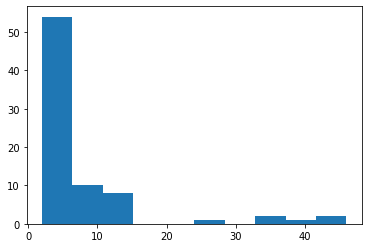

In [18]:
categorical_features_count = {'feature': [], 'counts':[]}

for f in categorical_features:

    categorical_features_count['feature'].append(f)
    
    categorical_features_count['counts'].append(len(np.unique(joint_dataset[f].dropna())  ) )


categorical_features_count = pd.DataFrame(categorical_features_count)
plt.hist(categorical_features_count['counts'])

In [19]:
categorical_features_to_one_hot = list( categorical_features_count[categorical_features_count['counts']!=2]['feature'])
len(categorical_features_to_one_hot)

67

In [20]:
len(categorical_features)

78

So, 67 our of 78 f features need to be one-hot encoded

In [21]:
joint_dataset = pd.get_dummies(joint_dataset,columns=categorical_features_to_one_hot)
joint_dataset

,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
LNR,,,,,,,,,,,,,,,,,,,,,
9626,2.0,1.0,3.0,1.0,1.0,0,0.0,0,3.0,3.0,...,0,0,0,0,1,0,0,0,0,1
143872,1.0,3.0,4.0,3.0,5.0,0,1.0,0,2.0,2.0,...,0,0,1,0,0,0,1,0,0,0
143873,2.0,1.0,3.0,1.0,2.0,0,0.0,0,4.0,4.0,...,0,0,1,0,0,0,0,0,0,1
143874,1.0,1.0,4.0,2.0,3.0,0,1.0,3,2.0,1.0,...,0,0,1,0,0,0,0,1,0,0
143888,1.0,5.0,3.0,2.0,4.0,0,0.0,0,2.0,3.0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825761,1.0,NaN,2.0,0.0,3.0,0,0.0,0,1.0,3.0,...,0,1,0,0,0,0,0,1,0,0
825771,1.0,5.0,4.0,3.0,3.0,0,1.0,0,1.0,0.0,...,0,0,0,0,1,0,0,1,0,0
825772,1.0,3.0,2.0,0.0,4.0,0,0.0,0,1.0,2.0,...,0,0,1,0,0,0,0,0,1,0


## 03.03. Encode ORDINAL Features

joint dataset comprises of three types of features: 

1. numerical - will be left unchanged
2. ordinal - will be encoded with label encoder, to be represented by numbers, hence preserving order
3. categorical -> have been one-hot encoded in the previous step


I will encode ordinal and categorical features as standardized integers. As seen above some classes comprise of high-value numbers.

Extract feature names that **ARE NOT NUMERICAL** (that need label encoding)

In [22]:
joint_dataset.shape

(932108, 893)

In [23]:
numerical_features = list(common_features[common_features['Type_x']=='numerical']['Attribute.1'])

not_numerical_features  = [f for f in joint_dataset.columns if f not in numerical_features]

In [24]:
from sklearn.preprocessing import LabelEncoder
LabelEncoders = { x: LabelEncoder() for x in not_numerical_features  }

CPU times: user 1.68 s, sys: 692 ms, total: 2.38 s
Wall time: 2.37 s


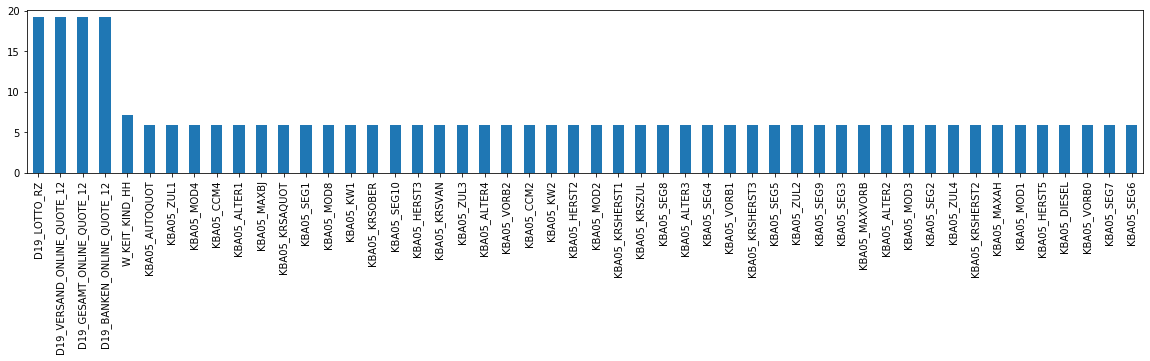

In [25]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [26]:
for idx,feature in enumerate(not_numerical_features):
    print("{}/{}: {}".format(idx+1,len(not_numerical_features),feature ))
    
    # NA mask - label encoder cannot handle missing values (i.e. NAs)
    not_na_mask =  joint_dataset[feature].notnull() # FALSE for NA, TRUE for some value
    
    joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )

1/885: KBA13_KMH_110
2/885: RELAT_AB
3/885: KBA13_BJ_1999
4/885: PLZ8_ANTG3
5/885: KBA13_SEG_MINIWAGEN


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )


6/885: D19_ENERGIE_RZ
7/885: KONSUMZELLE
8/885: D19_BANKEN_LOKAL_RZ
9/885: KBA05_SEG2
10/885: KBA05_ZUL4
11/885: FINANZ_UNAUFFAELLIGER
12/885: KBA05_MAXAH
13/885: D19_FREIZEIT_RZ
14/885: KBA13_SEG_OBERKLASSE
15/885: D19_SONSTIGE_RZ
16/885: KBA13_HALTER_35
17/885: KBA13_SEG_MINIVANS
18/885: KBA13_CCM_2500
19/885: D19_RATGEBER_RZ
20/885: KBA13_HALTER_30
21/885: KBA05_KRSKLEIN
22/885: D19_TELKO_REST_RZ
23/885: KBA13_VW
24/885: KBA13_CCM_1400_2500
25/885: KBA05_MAXSEG
26/885: D19_BANKEN_DIREKT_RZ
27/885: KBA13_SITZE_4
28/885: KBA13_SEG_KLEINWAGEN
29/885: KBA13_SITZE_6
30/885: KBA13_OPEL
31/885: KBA13_VORB_0
32/885: KBA05_FRAU
33/885: KBA05_MOD4
34/885: W_KEIT_KIND_HH
35/885: KBA05_CCM4
36/885: KBA13_SEG_GROSSRAUMVANS
37/885: SEMIO_ERL
38/885: ORTSGR_KLS9
39/885: KBA13_SEG_OBEREMITTELKLASSE
40/885: WOHNDAUER_2008
41/885: D19_GESAMT_ONLINE_QUOTE_12
42/885: D19_BANKEN_REST_RZ
43/885: KBA13_MOTOR
44/885: KBA05_MOD8
45/885: KBA13_BJ_2009
46/885: KBA05_KRSOBER
47/885: KBA05_ZUL1
48/885: DSL_FLAG

<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

267/885: GEMEINDETYP_11.0
268/885: GEMEINDETYP_12.0
269/885: GEMEINDETYP_21.0
270/885: GEMEINDETYP_22.0
271/885: GEMEINDETYP_30.0
272/885: GEMEINDETYP_40.0
273/885: GEMEINDETYP_50.0
274/885: CAMEO_DEU_2015_1A


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

275/885: CAMEO_DEU_2015_1B
276/885: CAMEO_DEU_2015_1C
277/885: CAMEO_DEU_2015_1D
278/885: CAMEO_DEU_2015_1E
279/885: CAMEO_DEU_2015_2A
280/885: CAMEO_DEU_2015_2B
281/885: CAMEO_DEU_2015_2C


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

282/885: CAMEO_DEU_2015_2D
283/885: CAMEO_DEU_2015_3A
284/885: CAMEO_DEU_2015_3B
285/885: CAMEO_DEU_2015_3C
286/885: CAMEO_DEU_2015_3D
287/885: CAMEO_DEU_2015_4A
288/885: CAMEO_DEU_2015_4B


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

289/885: CAMEO_DEU_2015_4C
290/885: CAMEO_DEU_2015_4D
291/885: CAMEO_DEU_2015_4E
292/885: CAMEO_DEU_2015_5A
293/885: CAMEO_DEU_2015_5B
294/885: CAMEO_DEU_2015_5C
295/885: CAMEO_DEU_2015_5D
296/885: CAMEO_DEU_2015_5E


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

297/885: CAMEO_DEU_2015_5F
298/885: CAMEO_DEU_2015_6A
299/885: CAMEO_DEU_2015_6B
300/885: CAMEO_DEU_2015_6C
301/885: CAMEO_DEU_2015_6D
302/885: CAMEO_DEU_2015_6E
303/885: CAMEO_DEU_2015_6F
304/885: CAMEO_DEU_2015_7A


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

305/885: CAMEO_DEU_2015_7B
306/885: CAMEO_DEU_2015_7C
307/885: CAMEO_DEU_2015_7D
308/885: CAMEO_DEU_2015_7E
309/885: CAMEO_DEU_2015_8A
310/885: CAMEO_DEU_2015_8B
311/885: CAMEO_DEU_2015_8C
312/885: CAMEO_DEU_2015_8D


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

313/885: CAMEO_DEU_2015_9A
314/885: CAMEO_DEU_2015_9B
315/885: CAMEO_DEU_2015_9C
316/885: CAMEO_DEU_2015_9D
317/885: CAMEO_DEU_2015_9E
318/885: CAMEO_DEU_2015_XX
319/885: LP_STATUS_FEIN_1.0
320/885: LP_STATUS_FEIN_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

321/885: LP_STATUS_FEIN_3.0
322/885: LP_STATUS_FEIN_4.0
323/885: LP_STATUS_FEIN_5.0
324/885: LP_STATUS_FEIN_6.0
325/885: LP_STATUS_FEIN_7.0
326/885: LP_STATUS_FEIN_8.0
327/885: LP_STATUS_FEIN_9.0
328/885: LP_STATUS_FEIN_10.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

329/885: D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_DIREKT
330/885: D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_GROSS
331/885: D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_LOKAL
332/885: D19_LETZTER_KAUF_BRANCHE_D19_BANKEN_REST
333/885: D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_GEH
334/885: D19_LETZTER_KAUF_BRANCHE_D19_BEKLEIDUNG_REST
335/885: D19_LETZTER_KAUF_BRANCHE_D19_BILDUNG
336/885: D19_LETZTER_KAUF_BRANCHE_D19_BIO_OEKO


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

337/885: D19_LETZTER_KAUF_BRANCHE_D19_BUCH_CD
338/885: D19_LETZTER_KAUF_BRANCHE_D19_DIGIT_SERV
339/885: D19_LETZTER_KAUF_BRANCHE_D19_DROGERIEARTIKEL
340/885: D19_LETZTER_KAUF_BRANCHE_D19_ENERGIE
341/885: D19_LETZTER_KAUF_BRANCHE_D19_FREIZEIT
342/885: D19_LETZTER_KAUF_BRANCHE_D19_GARTEN
343/885: D19_LETZTER_KAUF_BRANCHE_D19_HANDWERK
344/885: D19_LETZTER_KAUF_BRANCHE_D19_HAUS_DEKO


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

345/885: D19_LETZTER_KAUF_BRANCHE_D19_KINDERARTIKEL
346/885: D19_LETZTER_KAUF_BRANCHE_D19_KOSMETIK
347/885: D19_LETZTER_KAUF_BRANCHE_D19_LEBENSMITTEL
348/885: D19_LETZTER_KAUF_BRANCHE_D19_LOTTO
349/885: D19_LETZTER_KAUF_BRANCHE_D19_NAHRUNGSERGAENZUNG
350/885: D19_LETZTER_KAUF_BRANCHE_D19_RATGEBER
351/885: D19_LETZTER_KAUF_BRANCHE_D19_REISEN
352/885: D19_LETZTER_KAUF_BRANCHE_D19_SAMMELARTIKEL


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

353/885: D19_LETZTER_KAUF_BRANCHE_D19_SCHUHE
354/885: D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE
355/885: D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK
356/885: D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE
357/885: D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST
358/885: D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL
359/885: D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT
360/885: D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

361/885: D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN
362/885: D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT
363/885: D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
364/885: FIRMENDICHTE_1.0
365/885: FIRMENDICHTE_2.0
366/885: FIRMENDICHTE_3.0
367/885: FIRMENDICHTE_4.0
368/885: FIRMENDICHTE_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

369/885: AKT_DAT_KL_1.0
370/885: AKT_DAT_KL_2.0
371/885: AKT_DAT_KL_3.0
372/885: AKT_DAT_KL_4.0
373/885: AKT_DAT_KL_5.0
374/885: AKT_DAT_KL_6.0
375/885: AKT_DAT_KL_7.0
376/885: AKT_DAT_KL_8.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

377/885: AKT_DAT_KL_9.0
378/885: LP_LEBENSPHASE_GROB_0.0
379/885: LP_LEBENSPHASE_GROB_1.0
380/885: LP_LEBENSPHASE_GROB_2.0
381/885: LP_LEBENSPHASE_GROB_3.0
382/885: LP_LEBENSPHASE_GROB_4.0
383/885: LP_LEBENSPHASE_GROB_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

384/885: LP_LEBENSPHASE_GROB_6.0
385/885: LP_LEBENSPHASE_GROB_7.0
386/885: LP_LEBENSPHASE_GROB_8.0
387/885: LP_LEBENSPHASE_GROB_9.0
388/885: LP_LEBENSPHASE_GROB_10.0
389/885: LP_LEBENSPHASE_GROB_11.0
390/885: LP_LEBENSPHASE_GROB_12.0
391/885: UMFELD_ALT_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

392/885: UMFELD_ALT_2.0
393/885: UMFELD_ALT_3.0
394/885: UMFELD_ALT_4.0
395/885: UMFELD_ALT_5.0
396/885: D19_TELKO_ONLINE_QUOTE_12_0.0
397/885: D19_TELKO_ONLINE_QUOTE_12_3.0
398/885: D19_TELKO_ONLINE_QUOTE_12_5.0
399/885: D19_TELKO_ONLINE_QUOTE_12_7.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

400/885: D19_TELKO_ONLINE_QUOTE_12_10.0
401/885: KBA13_ANTG1_0.0
402/885: KBA13_ANTG1_1.0
403/885: KBA13_ANTG1_2.0
404/885: KBA13_ANTG1_3.0
405/885: KBA13_ANTG1_4.0
406/885: FINANZTYP_1


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

407/885: FINANZTYP_2
408/885: FINANZTYP_3
409/885: FINANZTYP_4
410/885: FINANZTYP_5
411/885: FINANZTYP_6
412/885: RETOURTYP_BK_S_1.0
413/885: RETOURTYP_BK_S_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

414/885: RETOURTYP_BK_S_3.0
415/885: RETOURTYP_BK_S_4.0
416/885: RETOURTYP_BK_S_5.0
417/885: SHOPPER_TYP_0.0
418/885: SHOPPER_TYP_1.0
419/885: SHOPPER_TYP_2.0
420/885: SHOPPER_TYP_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

421/885: VK_DISTANZ_1.0
422/885: VK_DISTANZ_2.0
423/885: VK_DISTANZ_3.0
424/885: VK_DISTANZ_4.0
425/885: VK_DISTANZ_5.0
426/885: VK_DISTANZ_6.0
427/885: VK_DISTANZ_7.0
428/885: VK_DISTANZ_8.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

429/885: VK_DISTANZ_9.0
430/885: VK_DISTANZ_10.0
431/885: VK_DISTANZ_11.0
432/885: VK_DISTANZ_12.0
433/885: VK_DISTANZ_13.0
434/885: MOBI_RASTER_1.0
435/885: MOBI_RASTER_2.0
436/885: MOBI_RASTER_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

437/885: MOBI_RASTER_4.0
438/885: MOBI_RASTER_5.0
439/885: MOBI_RASTER_6.0
440/885: VK_ZG11_1.0
441/885: VK_ZG11_2.0
442/885: VK_ZG11_3.0
443/885: VK_ZG11_4.0
444/885: VK_ZG11_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

445/885: VK_ZG11_6.0
446/885: VK_ZG11_7.0
447/885: VK_ZG11_8.0
448/885: VK_ZG11_9.0
449/885: VK_ZG11_10.0
450/885: VK_ZG11_11.0
451/885: CJT_TYP_1_1.0
452/885: CJT_TYP_1_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

453/885: CJT_TYP_1_3.0
454/885: CJT_TYP_1_4.0
455/885: CJT_TYP_1_5.0
456/885: ZABEOTYP_1
457/885: ZABEOTYP_2
458/885: ZABEOTYP_3
459/885: ZABEOTYP_4


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

460/885: ZABEOTYP_5
461/885: ZABEOTYP_6
462/885: CJT_TYP_3_1.0
463/885: CJT_TYP_3_2.0
464/885: CJT_TYP_3_3.0
465/885: CJT_TYP_3_4.0
466/885: CJT_TYP_3_5.0
467/885: D19_VERSI_DATUM_1


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

468/885: D19_VERSI_DATUM_2
469/885: D19_VERSI_DATUM_3
470/885: D19_VERSI_DATUM_4
471/885: D19_VERSI_DATUM_5
472/885: D19_VERSI_DATUM_6
473/885: D19_VERSI_DATUM_7
474/885: D19_VERSI_DATUM_8
475/885: D19_VERSI_DATUM_9


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

476/885: D19_VERSI_DATUM_10
477/885: HEALTH_TYP_1.0
478/885: HEALTH_TYP_2.0
479/885: HEALTH_TYP_3.0
480/885: WOHNLAGE_0.0
481/885: WOHNLAGE_1.0
482/885: WOHNLAGE_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

483/885: WOHNLAGE_3.0
484/885: WOHNLAGE_4.0
485/885: WOHNLAGE_5.0
486/885: WOHNLAGE_7.0
487/885: WOHNLAGE_8.0
488/885: UMFELD_JUNG_1.0
489/885: UMFELD_JUNG_2.0
490/885: UMFELD_JUNG_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

491/885: UMFELD_JUNG_4.0
492/885: UMFELD_JUNG_5.0
493/885: VHN_0.0
494/885: VHN_1.0
495/885: VHN_2.0
496/885: VHN_3.0
497/885: VHN_4.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

498/885: KBA05_MODTEMP_1.0
499/885: KBA05_MODTEMP_2.0
500/885: KBA05_MODTEMP_3.0
501/885: KBA05_MODTEMP_4.0
502/885: KBA05_MODTEMP_5.0
503/885: KBA05_MODTEMP_6.0
504/885: VHA_0.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

505/885: VHA_1.0
506/885: VHA_2.0
507/885: VHA_3.0
508/885: VHA_4.0
509/885: VHA_5.0
510/885: D19_VERSI_ONLINE_QUOTE_12_0.0
511/885: D19_VERSI_ONLINE_QUOTE_12_3.0
512/885: D19_VERSI_ONLINE_QUOTE_12_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

513/885: D19_VERSI_ONLINE_QUOTE_12_6.0
514/885: D19_VERSI_ONLINE_QUOTE_12_7.0
515/885: D19_VERSI_ONLINE_QUOTE_12_8.0
516/885: D19_VERSI_ONLINE_QUOTE_12_9.0
517/885: D19_VERSI_ONLINE_QUOTE_12_10.0
518/885: KOMBIALTER_1
519/885: KOMBIALTER_2
520/885: KOMBIALTER_3


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

521/885: KOMBIALTER_4
522/885: KOMBIALTER_9
523/885: CJT_TYP_5_1.0
524/885: CJT_TYP_5_2.0
525/885: CJT_TYP_5_3.0
526/885: CJT_TYP_5_4.0
527/885: CJT_TYP_5_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

528/885: D19_VERSI_OFFLINE_DATUM_1
529/885: D19_VERSI_OFFLINE_DATUM_2
530/885: D19_VERSI_OFFLINE_DATUM_3
531/885: D19_VERSI_OFFLINE_DATUM_4
532/885: D19_VERSI_OFFLINE_DATUM_5
533/885: D19_VERSI_OFFLINE_DATUM_6
534/885: D19_VERSI_OFFLINE_DATUM_7
535/885: D19_VERSI_OFFLINE_DATUM_8


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

536/885: D19_VERSI_OFFLINE_DATUM_9
537/885: D19_VERSI_OFFLINE_DATUM_10
538/885: LP_FAMILIE_GROB_1.0
539/885: LP_FAMILIE_GROB_2.0
540/885: LP_FAMILIE_GROB_3.0
541/885: CJT_TYP_4_1.0
542/885: CJT_TYP_4_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

543/885: CJT_TYP_4_3.0
544/885: CJT_TYP_4_4.0
545/885: CJT_TYP_4_5.0
546/885: GEBAEUDETYP_RASTER_1.0
547/885: GEBAEUDETYP_RASTER_2.0
548/885: GEBAEUDETYP_RASTER_3.0
549/885: GEBAEUDETYP_RASTER_4.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

550/885: GEBAEUDETYP_RASTER_5.0
551/885: RT_KEIN_ANREIZ_1.0
552/885: RT_KEIN_ANREIZ_2.0
553/885: RT_KEIN_ANREIZ_3.0
554/885: RT_KEIN_ANREIZ_4.0
555/885: RT_KEIN_ANREIZ_5.0
556/885: ARBEIT_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

557/885: ARBEIT_2.0
558/885: ARBEIT_3.0
559/885: ARBEIT_4.0
560/885: ARBEIT_5.0
561/885: ARBEIT_9.0
562/885: VERDICHTUNGSRAUM_0.0
563/885: VERDICHTUNGSRAUM_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

564/885: VERDICHTUNGSRAUM_2.0
565/885: VERDICHTUNGSRAUM_3.0
566/885: VERDICHTUNGSRAUM_4.0
567/885: VERDICHTUNGSRAUM_5.0
568/885: VERDICHTUNGSRAUM_6.0
569/885: VERDICHTUNGSRAUM_7.0
570/885: VERDICHTUNGSRAUM_8.0
571/885: VERDICHTUNGSRAUM_9.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

572/885: VERDICHTUNGSRAUM_10.0
573/885: VERDICHTUNGSRAUM_11.0
574/885: VERDICHTUNGSRAUM_12.0
575/885: VERDICHTUNGSRAUM_13.0
576/885: VERDICHTUNGSRAUM_14.0
577/885: VERDICHTUNGSRAUM_15.0
578/885: VERDICHTUNGSRAUM_16.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

579/885: VERDICHTUNGSRAUM_17.0
580/885: VERDICHTUNGSRAUM_18.0
581/885: VERDICHTUNGSRAUM_19.0
582/885: VERDICHTUNGSRAUM_20.0
583/885: VERDICHTUNGSRAUM_21.0
584/885: VERDICHTUNGSRAUM_22.0
585/885: VERDICHTUNGSRAUM_23.0
586/885: VERDICHTUNGSRAUM_24.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

587/885: VERDICHTUNGSRAUM_25.0
588/885: VERDICHTUNGSRAUM_26.0
589/885: VERDICHTUNGSRAUM_27.0
590/885: VERDICHTUNGSRAUM_28.0
591/885: VERDICHTUNGSRAUM_29.0
592/885: VERDICHTUNGSRAUM_30.0
593/885: VERDICHTUNGSRAUM_31.0
594/885: VERDICHTUNGSRAUM_32.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

595/885: VERDICHTUNGSRAUM_33.0
596/885: VERDICHTUNGSRAUM_34.0
597/885: VERDICHTUNGSRAUM_35.0
598/885: VERDICHTUNGSRAUM_36.0
599/885: VERDICHTUNGSRAUM_37.0
600/885: VERDICHTUNGSRAUM_38.0
601/885: VERDICHTUNGSRAUM_39.0
602/885: VERDICHTUNGSRAUM_40.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

603/885: VERDICHTUNGSRAUM_41.0
604/885: VERDICHTUNGSRAUM_42.0
605/885: VERDICHTUNGSRAUM_43.0
606/885: VERDICHTUNGSRAUM_44.0
607/885: VERDICHTUNGSRAUM_45.0
608/885: RT_UEBERGROESSE_0.0
609/885: RT_UEBERGROESSE_1.0
610/885: RT_UEBERGROESSE_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

611/885: RT_UEBERGROESSE_3.0
612/885: RT_UEBERGROESSE_4.0
613/885: RT_UEBERGROESSE_5.0
614/885: D19_VERSI_ONLINE_DATUM_1
615/885: D19_VERSI_ONLINE_DATUM_2
616/885: D19_VERSI_ONLINE_DATUM_3
617/885: D19_VERSI_ONLINE_DATUM_4
618/885: D19_VERSI_ONLINE_DATUM_5


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

619/885: D19_VERSI_ONLINE_DATUM_6
620/885: D19_VERSI_ONLINE_DATUM_7
621/885: D19_VERSI_ONLINE_DATUM_8
622/885: D19_VERSI_ONLINE_DATUM_9
623/885: D19_VERSI_ONLINE_DATUM_10
624/885: VK_DHT4A_1.0
625/885: VK_DHT4A_2.0
626/885: VK_DHT4A_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

627/885: VK_DHT4A_4.0
628/885: VK_DHT4A_5.0
629/885: VK_DHT4A_6.0
630/885: VK_DHT4A_7.0
631/885: VK_DHT4A_8.0
632/885: VK_DHT4A_9.0
633/885: VK_DHT4A_10.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

634/885: VK_DHT4A_11.0
635/885: GEBAEUDETYP_1.0
636/885: GEBAEUDETYP_2.0
637/885: GEBAEUDETYP_3.0
638/885: GEBAEUDETYP_4.0
639/885: GEBAEUDETYP_5.0
640/885: GEBAEUDETYP_6.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

641/885: GEBAEUDETYP_8.0
642/885: CJT_TYP_2_1.0
643/885: CJT_TYP_2_2.0
644/885: CJT_TYP_2_3.0
645/885: CJT_TYP_2_4.0
646/885: CJT_TYP_2_5.0
647/885: EINGEZOGENAM_HH_JAHR_1900.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

648/885: EINGEZOGENAM_HH_JAHR_1904.0
649/885: EINGEZOGENAM_HH_JAHR_1971.0
650/885: EINGEZOGENAM_HH_JAHR_1984.0
651/885: EINGEZOGENAM_HH_JAHR_1986.0
652/885: EINGEZOGENAM_HH_JAHR_1987.0
653/885: EINGEZOGENAM_HH_JAHR_1988.0
654/885: EINGEZOGENAM_HH_JAHR_1989.0
655/885: EINGEZOGENAM_HH_JAHR_1990.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

656/885: EINGEZOGENAM_HH_JAHR_1991.0
657/885: EINGEZOGENAM_HH_JAHR_1992.0
658/885: EINGEZOGENAM_HH_JAHR_1993.0
659/885: EINGEZOGENAM_HH_JAHR_1994.0
660/885: EINGEZOGENAM_HH_JAHR_1995.0
661/885: EINGEZOGENAM_HH_JAHR_1996.0
662/885: EINGEZOGENAM_HH_JAHR_1997.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

663/885: EINGEZOGENAM_HH_JAHR_1998.0
664/885: EINGEZOGENAM_HH_JAHR_1999.0
665/885: EINGEZOGENAM_HH_JAHR_2000.0
666/885: EINGEZOGENAM_HH_JAHR_2001.0
667/885: EINGEZOGENAM_HH_JAHR_2002.0
668/885: EINGEZOGENAM_HH_JAHR_2003.0
669/885: EINGEZOGENAM_HH_JAHR_2004.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

670/885: EINGEZOGENAM_HH_JAHR_2005.0
671/885: EINGEZOGENAM_HH_JAHR_2006.0
672/885: EINGEZOGENAM_HH_JAHR_2007.0
673/885: EINGEZOGENAM_HH_JAHR_2008.0
674/885: EINGEZOGENAM_HH_JAHR_2009.0
675/885: EINGEZOGENAM_HH_JAHR_2010.0
676/885: EINGEZOGENAM_HH_JAHR_2011.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

677/885: EINGEZOGENAM_HH_JAHR_2012.0
678/885: EINGEZOGENAM_HH_JAHR_2013.0
679/885: EINGEZOGENAM_HH_JAHR_2014.0
680/885: EINGEZOGENAM_HH_JAHR_2015.0
681/885: EINGEZOGENAM_HH_JAHR_2016.0
682/885: EINGEZOGENAM_HH_JAHR_2017.0
683/885: EINGEZOGENAM_HH_JAHR_2018.0
684/885: KBA13_BAUMAX_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

685/885: KBA13_BAUMAX_2.0
686/885: KBA13_BAUMAX_3.0
687/885: KBA13_BAUMAX_4.0
688/885: KBA13_BAUMAX_5.0
689/885: LP_LEBENSPHASE_FEIN_0.0
690/885: LP_LEBENSPHASE_FEIN_1.0
691/885: LP_LEBENSPHASE_FEIN_2.0
692/885: LP_LEBENSPHASE_FEIN_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

693/885: LP_LEBENSPHASE_FEIN_4.0
694/885: LP_LEBENSPHASE_FEIN_5.0
695/885: LP_LEBENSPHASE_FEIN_6.0
696/885: LP_LEBENSPHASE_FEIN_7.0
697/885: LP_LEBENSPHASE_FEIN_8.0
698/885: LP_LEBENSPHASE_FEIN_9.0
699/885: LP_LEBENSPHASE_FEIN_10.0
700/885: LP_LEBENSPHASE_FEIN_11.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

701/885: LP_LEBENSPHASE_FEIN_12.0
702/885: LP_LEBENSPHASE_FEIN_13.0
703/885: LP_LEBENSPHASE_FEIN_14.0
704/885: LP_LEBENSPHASE_FEIN_15.0
705/885: LP_LEBENSPHASE_FEIN_16.0
706/885: LP_LEBENSPHASE_FEIN_17.0
707/885: LP_LEBENSPHASE_FEIN_18.0
708/885: LP_LEBENSPHASE_FEIN_19.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

709/885: LP_LEBENSPHASE_FEIN_20.0
710/885: LP_LEBENSPHASE_FEIN_21.0
711/885: LP_LEBENSPHASE_FEIN_22.0
712/885: LP_LEBENSPHASE_FEIN_23.0
713/885: LP_LEBENSPHASE_FEIN_24.0
714/885: LP_LEBENSPHASE_FEIN_25.0
715/885: LP_LEBENSPHASE_FEIN_26.0
716/885: LP_LEBENSPHASE_FEIN_27.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

717/885: LP_LEBENSPHASE_FEIN_28.0
718/885: LP_LEBENSPHASE_FEIN_29.0
719/885: LP_LEBENSPHASE_FEIN_30.0
720/885: LP_LEBENSPHASE_FEIN_31.0
721/885: LP_LEBENSPHASE_FEIN_32.0
722/885: LP_LEBENSPHASE_FEIN_33.0
723/885: LP_LEBENSPHASE_FEIN_34.0
724/885: LP_LEBENSPHASE_FEIN_35.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

725/885: LP_LEBENSPHASE_FEIN_36.0
726/885: LP_LEBENSPHASE_FEIN_37.0
727/885: LP_LEBENSPHASE_FEIN_38.0
728/885: LP_LEBENSPHASE_FEIN_39.0
729/885: LP_LEBENSPHASE_FEIN_40.0
730/885: ALTERSKATEGORIE_GROB_1
731/885: ALTERSKATEGORIE_GROB_2
732/885: ALTERSKATEGORIE_GROB_3


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

733/885: ALTERSKATEGORIE_GROB_4
734/885: ALTERSKATEGORIE_GROB_9
735/885: KBA13_ANTG3_0.0
736/885: KBA13_ANTG3_1.0
737/885: KBA13_ANTG3_2.0
738/885: KBA13_ANTG3_3.0
739/885: KBA13_KMH_210_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

740/885: KBA13_KMH_210_2.0
741/885: KBA13_KMH_210_3.0
742/885: KBA13_KMH_210_4.0
743/885: KBA13_KMH_210_5.0
744/885: LP_FAMILIE_FEIN_0.0
745/885: LP_FAMILIE_FEIN_1.0
746/885: LP_FAMILIE_FEIN_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

747/885: LP_FAMILIE_FEIN_3.0
748/885: LP_FAMILIE_FEIN_4.0
749/885: LP_FAMILIE_FEIN_5.0
750/885: LP_FAMILIE_FEIN_6.0
751/885: LP_FAMILIE_FEIN_7.0
752/885: LP_FAMILIE_FEIN_8.0
753/885: LP_FAMILIE_FEIN_9.0
754/885: LP_FAMILIE_FEIN_10.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

755/885: LP_FAMILIE_FEIN_11.0
756/885: KBA13_ANTG4_0.0
757/885: KBA13_ANTG4_1.0
758/885: KBA13_ANTG4_2.0
759/885: KBA13_ANTG2_0.0
760/885: KBA13_ANTG2_1.0
761/885: KBA13_ANTG2_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

762/885: KBA13_ANTG2_3.0
763/885: KBA13_ANTG2_4.0
764/885: STRUKTURTYP_1.0
765/885: STRUKTURTYP_2.0
766/885: STRUKTURTYP_3.0
767/885: CJT_TYP_6_1.0
768/885: CJT_TYP_6_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

769/885: CJT_TYP_6_3.0
770/885: CJT_TYP_6_4.0
771/885: CJT_TYP_6_5.0
772/885: PRAEGENDE_JUGENDJAHRE_1.0
773/885: PRAEGENDE_JUGENDJAHRE_2.0
774/885: PRAEGENDE_JUGENDJAHRE_3.0
775/885: PRAEGENDE_JUGENDJAHRE_4.0
776/885: PRAEGENDE_JUGENDJAHRE_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

777/885: PRAEGENDE_JUGENDJAHRE_6.0
778/885: PRAEGENDE_JUGENDJAHRE_7.0
779/885: PRAEGENDE_JUGENDJAHRE_8.0
780/885: PRAEGENDE_JUGENDJAHRE_9.0
781/885: PRAEGENDE_JUGENDJAHRE_10.0
782/885: PRAEGENDE_JUGENDJAHRE_11.0
783/885: PRAEGENDE_JUGENDJAHRE_12.0
784/885: PRAEGENDE_JUGENDJAHRE_13.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

785/885: PRAEGENDE_JUGENDJAHRE_14.0
786/885: PRAEGENDE_JUGENDJAHRE_15.0
787/885: D19_KONSUMTYP_MAX_1
788/885: D19_KONSUMTYP_MAX_2
789/885: D19_KONSUMTYP_MAX_3
790/885: D19_KONSUMTYP_MAX_4
791/885: D19_KONSUMTYP_MAX_8


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

792/885: D19_KONSUMTYP_MAX_9
793/885: KBA05_HERSTTEMP_1.0
794/885: KBA05_HERSTTEMP_2.0
795/885: KBA05_HERSTTEMP_3.0
796/885: KBA05_HERSTTEMP_4.0
797/885: KBA05_HERSTTEMP_5.0
798/885: D19_KONSUMTYP_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

799/885: D19_KONSUMTYP_2.0
800/885: D19_KONSUMTYP_3.0
801/885: D19_KONSUMTYP_4.0
802/885: D19_KONSUMTYP_5.0
803/885: D19_KONSUMTYP_6.0
804/885: D19_KONSUMTYP_9.0
805/885: RT_SCHNAEPPCHEN_1.0
806/885: RT_SCHNAEPPCHEN_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

807/885: RT_SCHNAEPPCHEN_3.0
808/885: RT_SCHNAEPPCHEN_4.0
809/885: RT_SCHNAEPPCHEN_5.0
810/885: CJT_GESAMTTYP_1.0
811/885: CJT_GESAMTTYP_2.0
812/885: CJT_GESAMTTYP_3.0
813/885: CJT_GESAMTTYP_4.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

814/885: CJT_GESAMTTYP_5.0
815/885: CJT_GESAMTTYP_6.0
816/885: GFK_URLAUBERTYP_1.0
817/885: GFK_URLAUBERTYP_2.0
818/885: GFK_URLAUBERTYP_3.0
819/885: GFK_URLAUBERTYP_4.0
820/885: GFK_URLAUBERTYP_5.0
821/885: GFK_URLAUBERTYP_6.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

822/885: GFK_URLAUBERTYP_7.0
823/885: GFK_URLAUBERTYP_8.0
824/885: GFK_URLAUBERTYP_9.0
825/885: GFK_URLAUBERTYP_10.0
826/885: GFK_URLAUBERTYP_11.0
827/885: GFK_URLAUBERTYP_12.0
828/885: KBA05_MAXHERST_1.0
829/885: KBA05_MAXHERST_2.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

830/885: KBA05_MAXHERST_3.0
831/885: KBA05_MAXHERST_4.0
832/885: KBA05_MAXHERST_5.0
833/885: D19_SOZIALES_0.0
834/885: D19_SOZIALES_1.0
835/885: D19_SOZIALES_2.0
836/885: D19_SOZIALES_3.0
837/885: D19_SOZIALES_4.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

838/885: D19_SOZIALES_5.0
839/885: ALTERSKATEGORIE_FEIN_0.0
840/885: ALTERSKATEGORIE_FEIN_1.0
841/885: ALTERSKATEGORIE_FEIN_2.0
842/885: ALTERSKATEGORIE_FEIN_3.0
843/885: ALTERSKATEGORIE_FEIN_4.0
844/885: ALTERSKATEGORIE_FEIN_5.0
845/885: ALTERSKATEGORIE_FEIN_6.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

846/885: ALTERSKATEGORIE_FEIN_7.0
847/885: ALTERSKATEGORIE_FEIN_8.0
848/885: ALTERSKATEGORIE_FEIN_9.0
849/885: ALTERSKATEGORIE_FEIN_10.0
850/885: ALTERSKATEGORIE_FEIN_11.0
851/885: ALTERSKATEGORIE_FEIN_12.0
852/885: ALTERSKATEGORIE_FEIN_13.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

853/885: ALTERSKATEGORIE_FEIN_14.0
854/885: ALTERSKATEGORIE_FEIN_15.0
855/885: ALTERSKATEGORIE_FEIN_16.0
856/885: ALTERSKATEGORIE_FEIN_17.0
857/885: ALTERSKATEGORIE_FEIN_18.0
858/885: ALTERSKATEGORIE_FEIN_19.0
859/885: ALTERSKATEGORIE_FEIN_20.0
860/885: ALTERSKATEGORIE_FEIN_21.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

861/885: ALTERSKATEGORIE_FEIN_22.0
862/885: ALTERSKATEGORIE_FEIN_23.0
863/885: ALTERSKATEGORIE_FEIN_24.0
864/885: ALTERSKATEGORIE_FEIN_25.0
865/885: ANZ_KINDER_0.0
866/885: ANZ_KINDER_1.0
867/885: ANZ_KINDER_2.0
868/885: ANZ_KINDER_3.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

869/885: ANZ_KINDER_4.0
870/885: ANZ_KINDER_5.0
871/885: ANZ_KINDER_6.0
872/885: ANZ_KINDER_7.0
873/885: ANZ_KINDER_8.0
874/885: ANZ_KINDER_9.0
875/885: ANZ_KINDER_11.0
876/885: KBA13_HHZ_1.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

877/885: KBA13_HHZ_2.0
878/885: KBA13_HHZ_3.0
879/885: KBA13_HHZ_4.0
880/885: KBA13_HHZ_5.0
881/885: KBA13_GBZ_1.0
882/885: KBA13_GBZ_2.0
883/885: KBA13_GBZ_3.0
884/885: KBA13_GBZ_4.0
885/885: KBA13_GBZ_5.0


<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_dataset[feature][not_na_mask] = LabelEncoders[feature].fit_transform(  joint_dataset[feature][not_na_mask]  )
<ipython-input-26-ece86c9d8e66>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

CPU times: user 1.07 s, sys: 224 ms, total: 1.29 s
Wall time: 1.29 s


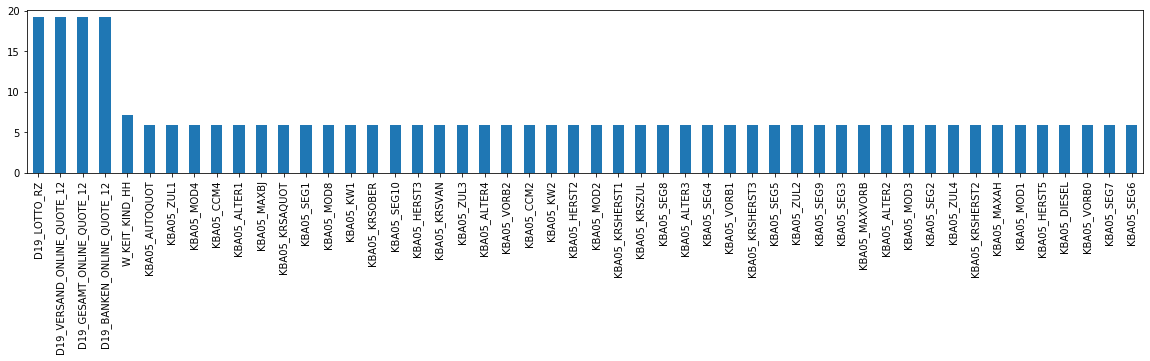

In [27]:
%%time
empty_cells = pd.isnull(joint_dataset).sum()*100.0/joint_dataset.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

## 03.04 Impute features

In [43]:
joint_dataset.drop('dataset',inplace=True,axis='columns')
not_numerical_features.remove('dataset')


In [29]:
%%time
import sklearn 
from sklearn.experimental import enable_iterative_imputer
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.impute import IterativeImputer

ie = IterativeImputer(n_nearest_features=10) # 10 is fine, takes around 40 minutes on my computer

joint_dataset_imputed = ie.fit_transform(joint_dataset) # ~40min, returns numpy array
joint_dataset_imputed_df = pd.DataFrame(joint_dataset_imputed, columns= joint_dataset.columns )


The scikit-learn version is 0.22.1.


/home/robert_remote/anaconda3/envs/mlend/lib/python3.8/site-packages/sklearn/impute/_iterative.py:637: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


CPU times: user 4h 27min 3s, sys: 4min 18s, total: 4h 31min 22s
Wall time: 36min 31s


We've used an `InterativeImputer` for numerical and ordinal/categorical features. For the latter the imputer treated them as numerical values, and due to the nature of Bayesian imputation, these values would not necessarily be intigers. In the next step I round the values for categories to the closes integer corresponding to that class.



In [32]:
joint_dataset_imputed_df.shape

(932108, 892)

In [33]:
for i,feature in enumerate(not_numerical_features):
    print("{}/{} {}".format(i+1,len(not_numerical_features), feature))
    joint_dataset_imputed_df[feature] = joint_dataset_imputed_df[feature].round()

1/885 KBA13_KMH_110
2/885 RELAT_AB
3/885 KBA13_BJ_1999
4/885 PLZ8_ANTG3
5/885 KBA13_SEG_MINIWAGEN
6/885 D19_ENERGIE_RZ
7/885 KONSUMZELLE
8/885 D19_BANKEN_LOKAL_RZ
9/885 KBA05_SEG2
10/885 KBA05_ZUL4
11/885 FINANZ_UNAUFFAELLIGER
12/885 KBA05_MAXAH
13/885 D19_FREIZEIT_RZ
14/885 KBA13_SEG_OBERKLASSE
15/885 D19_SONSTIGE_RZ
16/885 KBA13_HALTER_35
17/885 KBA13_SEG_MINIVANS
18/885 KBA13_CCM_2500
19/885 D19_RATGEBER_RZ
20/885 KBA13_HALTER_30
21/885 KBA05_KRSKLEIN
22/885 D19_TELKO_REST_RZ
23/885 KBA13_VW
24/885 KBA13_CCM_1400_2500
25/885 KBA05_MAXSEG
26/885 D19_BANKEN_DIREKT_RZ
27/885 KBA13_SITZE_4
28/885 KBA13_SEG_KLEINWAGEN
29/885 KBA13_SITZE_6
30/885 KBA13_OPEL
31/885 KBA13_VORB_0
32/885 KBA05_FRAU
33/885 KBA05_MOD4
34/885 W_KEIT_KIND_HH
35/885 KBA05_CCM4
36/885 KBA13_SEG_GROSSRAUMVANS
37/885 SEMIO_ERL
38/885 ORTSGR_KLS9
39/885 KBA13_SEG_OBEREMITTELKLASSE
40/885 WOHNDAUER_2008
41/885 D19_GESAMT_ONLINE_QUOTE_12
42/885 D19_BANKEN_REST_RZ
43/885 KBA13_MOTOR
44/885 KBA05_MOD8
45/885 KBA13_BJ_2009

KeyError: 'dataset'

# TODO
- save the scalers

And now compare the number of unique classes before and after imputation:

In [36]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(not_numerical_features):
 
    print("{}/{}: {}".format(idx+1,len(not_numerical_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/885: KBA13_KMH_110
2/885: RELAT_AB
3/885: KBA13_BJ_1999
4/885: PLZ8_ANTG3
5/885: KBA13_SEG_MINIWAGEN
6/885: D19_ENERGIE_RZ
7/885: KONSUMZELLE
8/885: D19_BANKEN_LOKAL_RZ
9/885: KBA05_SEG2
10/885: KBA05_ZUL4
11/885: FINANZ_UNAUFFAELLIGER
12/885: KBA05_MAXAH
13/885: D19_FREIZEIT_RZ
14/885: KBA13_SEG_OBERKLASSE
15/885: D19_SONSTIGE_RZ
16/885: KBA13_HALTER_35
17/885: KBA13_SEG_MINIVANS
18/885: KBA13_CCM_2500
19/885: D19_RATGEBER_RZ
20/885: KBA13_HALTER_30
21/885: KBA05_KRSKLEIN
22/885: D19_TELKO_REST_RZ
23/885: KBA13_VW
24/885: KBA13_CCM_1400_2500
25/885: KBA05_MAXSEG
26/885: D19_BANKEN_DIREKT_RZ
27/885: KBA13_SITZE_4
28/885: KBA13_SEG_KLEINWAGEN
29/885: KBA13_SITZE_6
30/885: KBA13_OPEL
31/885: KBA13_VORB_0
32/885: KBA05_FRAU
33/885: KBA05_MOD4
34/885: W_KEIT_KIND_HH
35/885: KBA05_CCM4
36/885: KBA13_SEG_GROSSRAUMVANS
37/885: SEMIO_ERL
38/885: ORTSGR_KLS9
39/885: KBA13_SEG_OBEREMITTELKLASSE
40/885: WOHNDAUER_2008
41/885: D19_GESAMT_ONLINE_QUOTE_12
42/885: D19_BANKEN_REST_RZ
43/885: KBA13_M

,Attribute,Before_imputation,After_imputation
225,CAMEO_DEUINTL_2015,22,22
40,D19_GESAMT_ONLINE_QUOTE_12,11,11
73,D19_BANKEN_ONLINE_QUOTE_12,11,11
105,D19_VERSAND_ONLINE_QUOTE_12,11,11
37,ORTSGR_KLS9,10,10
...,...,...,...
459,ZABEOTYP_6,2,2
460,CJT_TYP_3_1.0,2,2
461,CJT_TYP_3_2.0,2,2
462,CJT_TYP_3_3.0,2,2


In [38]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation
191,D19_LOTTO_RZ,8,11
242,ONLINE_AFFINITAET,6,7
234,MOBI_REGIO,6,10
255,PRAEGENDE_JUGENDJAHRE_SIM,6,7235
33,W_KEIT_KIND_HH,6,7
173,KBA05_KRSAQUOT,5,7
193,KBA13_HALTER_20,5,6
175,PLZ8_BAUMAX,5,6
256,CAMEO_DEUINTL_2015_SIM,5,1961
201,KBA05_ANTG1,5,6


As we can see some features exhibited more classes than anticipated. I will replace the new numerical labels for classes as unknowns

In [44]:
# replace seemingly new classes with NANs
for idx,feature in enumerate(not_numerical_features):
 
    print("{}/{}: {}".format(idx+1,len(not_numerical_features),feature))
    imputed_clusters = np.unique(joint_dataset_imputed_df[feature].dropna())
    original_clusters = np.unique(joint_dataset[feature].dropna())


    unobserved_classes = set(imputed_clusters).difference( set(original_clusters) )
    for uclass in unobserved_classes:
        joint_dataset_imputed_df[feature].replace(uclass,np.nan, inplace=True)
        

1/884: KBA13_KMH_110
2/884: RELAT_AB
3/884: KBA13_BJ_1999
4/884: PLZ8_ANTG3
5/884: KBA13_SEG_MINIWAGEN
6/884: D19_ENERGIE_RZ
7/884: KONSUMZELLE
8/884: D19_BANKEN_LOKAL_RZ
9/884: KBA05_SEG2
10/884: KBA05_ZUL4
11/884: FINANZ_UNAUFFAELLIGER
12/884: KBA05_MAXAH
13/884: D19_FREIZEIT_RZ
14/884: KBA13_SEG_OBERKLASSE
15/884: D19_SONSTIGE_RZ
16/884: KBA13_HALTER_35
17/884: KBA13_SEG_MINIVANS
18/884: KBA13_CCM_2500
19/884: D19_RATGEBER_RZ
20/884: KBA13_HALTER_30
21/884: KBA05_KRSKLEIN
22/884: D19_TELKO_REST_RZ
23/884: KBA13_VW
24/884: KBA13_CCM_1400_2500
25/884: KBA05_MAXSEG
26/884: D19_BANKEN_DIREKT_RZ
27/884: KBA13_SITZE_4
28/884: KBA13_SEG_KLEINWAGEN
29/884: KBA13_SITZE_6
30/884: KBA13_OPEL
31/884: KBA13_VORB_0
32/884: KBA05_FRAU
33/884: KBA05_MOD4
34/884: W_KEIT_KIND_HH
35/884: KBA05_CCM4
36/884: KBA13_SEG_GROSSRAUMVANS
37/884: SEMIO_ERL
38/884: ORTSGR_KLS9
39/884: KBA13_SEG_OBEREMITTELKLASSE
40/884: WOHNDAUER_2008
41/884: D19_GESAMT_ONLINE_QUOTE_12
42/884: D19_BANKEN_REST_RZ
43/884: KBA13_M

In [45]:
imputed_features_counts = {}
imputed_features_counts['Attribute'] =[]
imputed_features_counts['Before_imputation'] =[]
imputed_features_counts['After_imputation'] =[]

for idx,f in enumerate(not_numerical_features):
    print("{}/{}: {}".format(idx+1,len(not_numerical_features),f))
    
    imputed_features_counts['Attribute'].append(f)

    uniq_before = len(np.unique(joint_dataset[f].dropna() ))
    imputed_features_counts['Before_imputation'].append(uniq_before)
    
    uniq_after =   len(np.unique(joint_dataset_imputed_df[f].dropna() ))
    imputed_features_counts['After_imputation'].append(uniq_after)
    
imputed_features_counts = pd.DataFrame.from_dict(imputed_features_counts)
imputed_features_counts.sort_values('Before_imputation',ascending=False, inplace=True)
imputed_features_counts

1/884: KBA13_KMH_110
2/884: RELAT_AB
3/884: KBA13_BJ_1999
4/884: PLZ8_ANTG3
5/884: KBA13_SEG_MINIWAGEN
6/884: D19_ENERGIE_RZ
7/884: KONSUMZELLE
8/884: D19_BANKEN_LOKAL_RZ
9/884: KBA05_SEG2
10/884: KBA05_ZUL4
11/884: FINANZ_UNAUFFAELLIGER
12/884: KBA05_MAXAH
13/884: D19_FREIZEIT_RZ
14/884: KBA13_SEG_OBERKLASSE
15/884: D19_SONSTIGE_RZ
16/884: KBA13_HALTER_35
17/884: KBA13_SEG_MINIVANS
18/884: KBA13_CCM_2500
19/884: D19_RATGEBER_RZ
20/884: KBA13_HALTER_30
21/884: KBA05_KRSKLEIN
22/884: D19_TELKO_REST_RZ
23/884: KBA13_VW
24/884: KBA13_CCM_1400_2500
25/884: KBA05_MAXSEG
26/884: D19_BANKEN_DIREKT_RZ
27/884: KBA13_SITZE_4
28/884: KBA13_SEG_KLEINWAGEN
29/884: KBA13_SITZE_6
30/884: KBA13_OPEL
31/884: KBA13_VORB_0
32/884: KBA05_FRAU
33/884: KBA05_MOD4
34/884: W_KEIT_KIND_HH
35/884: KBA05_CCM4
36/884: KBA13_SEG_GROSSRAUMVANS
37/884: SEMIO_ERL
38/884: ORTSGR_KLS9
39/884: KBA13_SEG_OBEREMITTELKLASSE
40/884: WOHNDAUER_2008
41/884: D19_GESAMT_ONLINE_QUOTE_12
42/884: D19_BANKEN_REST_RZ
43/884: KBA13_M

,Attribute,Before_imputation,After_imputation
225,CAMEO_DEUINTL_2015,22,22
40,D19_GESAMT_ONLINE_QUOTE_12,11,11
73,D19_BANKEN_ONLINE_QUOTE_12,11,11
105,D19_VERSAND_ONLINE_QUOTE_12,11,11
37,ORTSGR_KLS9,10,10
...,...,...,...
459,ZABEOTYP_6,2,2
460,CJT_TYP_3_1.0,2,2
461,CJT_TYP_3_2.0,2,2
462,CJT_TYP_3_3.0,2,2


In [46]:
imputed_features_counts[imputed_features_counts['Before_imputation']!=imputed_features_counts['After_imputation']]

,Attribute,Before_imputation,After_imputation


CPU times: user 1.12 s, sys: 76 ms, total: 1.2 s
Wall time: 1.2 s


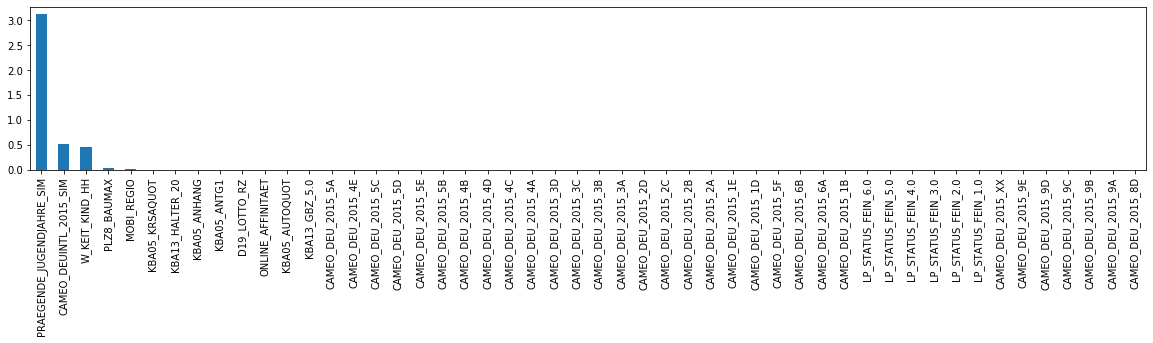

In [47]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df).sum()*100.0/joint_dataset_imputed_df.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

# Second imputation - simple frequency imputer

After we've used a more complicated Bayesian multivariate imputer, we still have a small portion of missing values. We can either remove them, or use a naive imputation method: a scikit-learn instance of SimpleImputer, and replace all missing values with the most frequently occuring one. Since the missingness is small, this would not introduce any big errors. 

Finally we save this dataset as `joint_dataset_imputed.csv` for subsequent analyses.

In [48]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy= 'most_frequent')

joint_dataset_imputed_df = pd.DataFrame(imputer.fit_transform(joint_dataset_imputed_df),columns= joint_dataset_imputed_df.columns)

CPU times: user 1.11 s, sys: 92.1 ms, total: 1.2 s
Wall time: 1.2 s


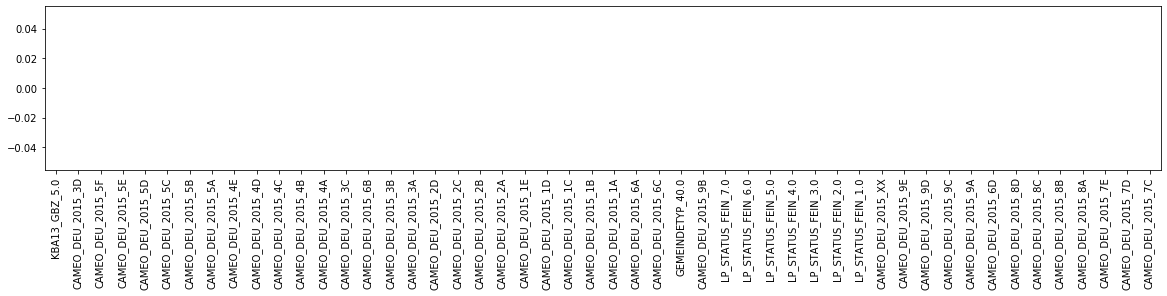

In [49]:
%%time
empty_cells = pd.isnull(joint_dataset_imputed_df).sum()*100.0/joint_dataset_imputed_df.shape[0]
empty_cells = empty_cells.sort_values(ascending=False)
empty_cells[:50].plot(figsize=(20,3),kind='bar') # bar plot of first 50 most missing features

In [50]:
joint_dataset_imputed_df.head()

,KBA13_KMH_110,RELAT_AB,KBA13_BJ_1999,PLZ8_ANTG3,KBA13_SEG_MINIWAGEN,D19_ENERGIE_RZ,KONSUMZELLE,D19_BANKEN_LOKAL_RZ,KBA05_SEG2,KBA05_ZUL4,...,KBA13_HHZ_1.0,KBA13_HHZ_2.0,KBA13_HHZ_3.0,KBA13_HHZ_4.0,KBA13_HHZ_5.0,KBA13_GBZ_1.0,KBA13_GBZ_2.0,KBA13_GBZ_3.0,KBA13_GBZ_4.0,KBA13_GBZ_5.0
0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,2.0,3.0,3.0,4.0,0.0,1.0,0.0,1.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,3.0,2.0,2.0,0.0,1.0,3.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [51]:
joint_dataset_imputed_df.to_csv("../arvato_data_processed/joint_dataset_imputed.csv")

For unsupervised analysis the dataset needs to be further scaled, but that is going to be applied in the next notebook. 

For now, we have **prepared a final dataset** containing samples (rows) coming from general population (`AZDIAS`) of Germany, and Arvato customers (`customers`). 

For each I've addressed the problems with features: encoded properly the missing values, found feature names that correspond to metadata information including feature names that slightly differ between given data and metadata. I applied filtering per feature and sample based on pre-defined missingness thresholds.

Then, I combined these two datasets into one, found common set of features. I performed feature encoding with `LabelEncoder` to represent categorical and ordinal features with integers. Finally I applied two-step imputation. First a sophisticated IterativeImputer was applied to infer the most likely value for a missing entry using 10 most correlated features. This has proven to be computationally tractable (feasable in a timespan of minutes). Inferred values were converted back to labels using rounding procedure. Finally inferred values that would constitute a new class were replaced with  `NA` and then inferred with `SimpleImputer` using most frequently occuring value. Because later PCA analysis requires all values to be available (i.e. no `NA` values), this approach would provide high retention of values, with removal of highly missing individuals/features for which imputation would not be advised. 

In [54]:
list(joint_dataset_imputed_df.columns)

['KBA13_KMH_110',
 'RELAT_AB',
 'KBA13_BJ_1999',
 'PLZ8_ANTG3',
 'KBA13_SEG_MINIWAGEN',
 'D19_ENERGIE_RZ',
 'KONSUMZELLE',
 'D19_BANKEN_LOKAL_RZ',
 'KBA05_SEG2',
 'KBA05_ZUL4',
 'FINANZ_UNAUFFAELLIGER',
 'KBA05_MAXAH',
 'D19_FREIZEIT_RZ',
 'KBA13_SEG_OBERKLASSE',
 'D19_SONSTIGE_RZ',
 'KBA13_HALTER_35',
 'KBA13_SEG_MINIVANS',
 'KBA13_CCM_2500',
 'D19_RATGEBER_RZ',
 'KBA13_HALTER_30',
 'KBA05_KRSKLEIN',
 'D19_TELKO_REST_RZ',
 'KBA13_VW',
 'KBA13_CCM_1400_2500',
 'KBA05_MAXSEG',
 'D19_BANKEN_DIREKT_RZ',
 'KBA13_SITZE_4',
 'KBA13_SEG_KLEINWAGEN',
 'KBA13_SITZE_6',
 'KBA13_OPEL',
 'KBA13_VORB_0',
 'KBA05_FRAU',
 'KBA05_MOD4',
 'W_KEIT_KIND_HH',
 'KBA05_CCM4',
 'KBA13_SEG_GROSSRAUMVANS',
 'SEMIO_ERL',
 'ORTSGR_KLS9',
 'KBA13_SEG_OBEREMITTELKLASSE',
 'WOHNDAUER_2008',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_BANKEN_REST_RZ',
 'KBA13_MOTOR',
 'KBA05_MOD8',
 'KBA13_BJ_2009',
 'KBA05_KRSOBER',
 'KBA05_ZUL1',
 'DSL_FLAG',
 'PLZ8_ANTG1',
 'KBA13_CCM_3001',
 'D19_GARTEN_RZ',
 'KBA13_CCM_0_1400',
 'D19_